In [1]:
library(tidyverse)
library(ggplot2)
library(haven)
library(stargazer)
library(broom)
library(knitr)
library(kableExtra)

Warning message:
"package 'tidyverse' was built under R version 4.4.2"
Warning message:
"package 'ggplot2' was built under R version 4.4.2"
Warning message:
"package 'dplyr' was built under R version 4.4.2"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 


Warning message:
"package 'kableExtra' was built under R version 4.4.2"

Attaching 

In [2]:
# Read in the dataset from relative path
census_data <- read_dta("../census_2021_indiv_Stata_dta_v2/cen_ind_2021_pumf_v2.dta")|>
    select(ppsort:weight)|>
    glimpse()

Rows: 980,868
Columns: 128
$ ppsort           <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16…
$ aboid            <dbl+lbl> 6, 6, 1, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6…
$ agegrp           <dbl+lbl> 13, 11, 13, 16, 18, 16, 16, 16, 11, 12, 16, 13, 1…
$ ageimm           <dbl+lbl>  7,  5, 99, 99, 99, 99, 99,  7, 99,  6, 99, 99,  …
$ attsch           <dbl+lbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 2, 2…
$ bfnmemb          <dbl+lbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ bedrm            <dbl+lbl> 4, 3, 0, 4, 3, 4, 3, 4, 4, 4, 1, 4, 5, 2, 2, 2, 3…
$ CFInc            <dbl+lbl> 30, 18,  7, 15, 13,  1, 10, 30, 25, 22,  9, 33, 2…
$ CFInc_AT         <dbl+lbl> 27, 18,  7, 15, 13,  1, 10, 27, 24, 22,  9, 32, 2…
$ cfstat           <dbl+lbl> 2, 2, 6, 2, 3, 7, 1, 1, 2, 2, 1, 2, 2, 1, 5, 5, 5…
$ chdbn            <dbl> 88888888, 11500, 99999999, 99999999, 99999999, 999999…
$ CIP2021          <dbl+lbl>  7,  8, 13, 10, 13, 13,  4,  4, 88, 13,  7,  5, 1…
$ CIP2021_STE

Based on the documentation, we should study the `lfact` to form our dependent variable `is_retired`. Then, I would use the variable `pkids` as the treatment of having one or more kids

In [3]:
# Create the is_retired variable based on labour force status, in which 1 means retired and 0 means not
# We typically use the observations claiming they are not in the labour force as being "retired"
census_data <- census_data|>
    filter(! lfact %in% c(88, 99))|>
    mutate(is_retired = ifelse((lfact %in% c(11, 12, 13, 14)), 1, 0))

census_data|>
    group_by(is_retired)|>
    summarize(count = n(), prop = count/nrow(census_data))

is_retired,count,prop
<dbl>,<int>,<dbl>
0,521117,0.6368903
1,297104,0.3631097


In [4]:
# Filter the dataset to keep those observations with kids in their household
# We would also handle all the covariates here
census_data <- census_data|>
    filter(!pkids %in% c(8,9))|>
    filter(agegrp != 88)|>
    filter(marsth != 8)|>
    filter(dpgrsum != 88)|>
    filter(!hdgree %in% c(88, 99))|>
    filter(CFInc_AT != 88)|>
    filter(!naics %in% c(888, 999))
    

# Note that for this variable 1 means with kids and 0 means without kids
census_data|>
    group_by(pkids)|>
    summarize(count = n(), prop = count/nrow(census_data))

pkids,count,prop
<dbl+lbl>,<int>,<dbl>
0,127252,0.3053972
1,289425,0.6946028


is_retired,pkids,count,group_prop
<dbl>,<dbl+lbl>,<int>,<dbl>
0,0,114559,0.3007193
0,1,266391,0.6992807
1,0,12693,0.3552775
1,1,23034,0.6447225


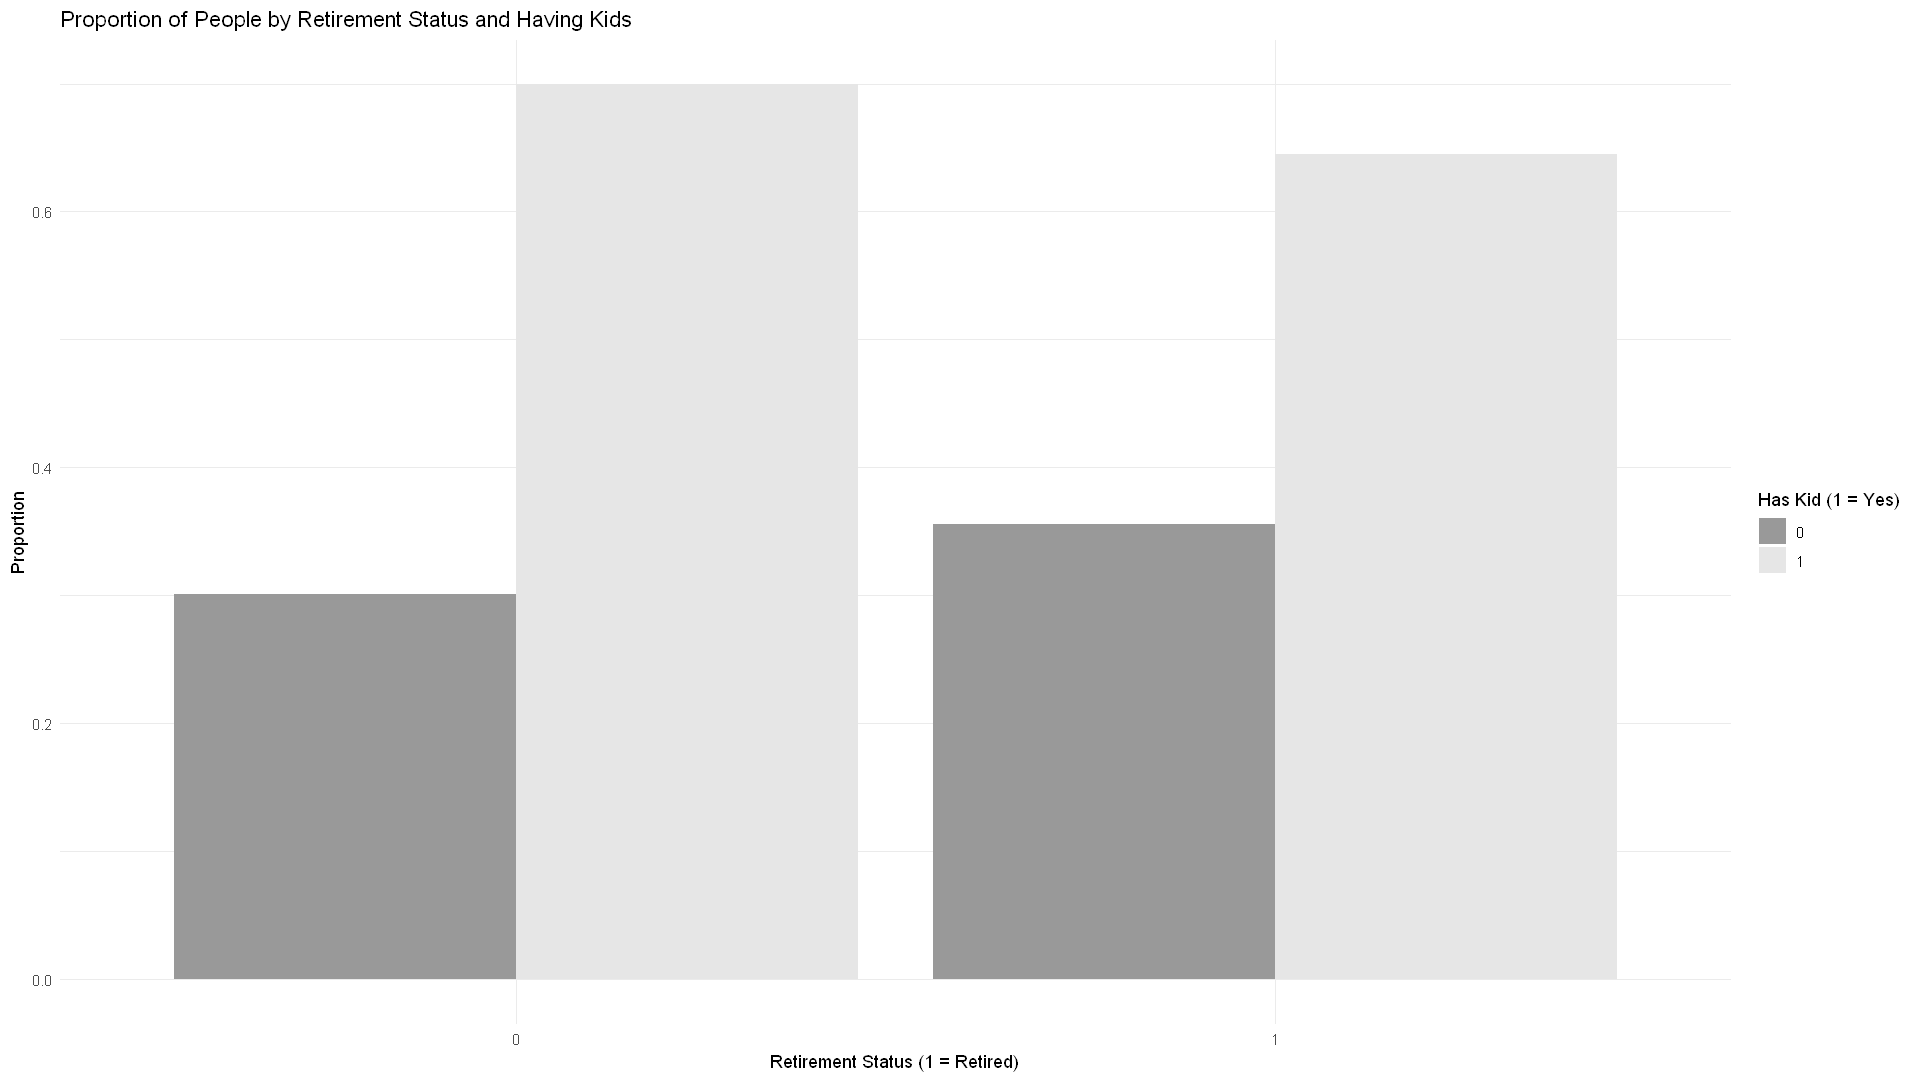

In [5]:
options(repr.plot.width = 16, repr.plot.height = 9)

retirement_kids <- census_data|>
    group_by(is_retired, pkids)|>
    summarize(count = n(), .groups = "drop_last") |>
    mutate(group_prop = count / sum(count)) |>
    ungroup()

retirement_kids_dist <- retirement_kids|>
    ggplot(aes(x = factor(is_retired), y = group_prop, fill = factor(pkids))) +
    geom_bar(stat = "identity", position = "dodge") +
    labs(
        x = "Retirement Status (1 = Retired)",
        y = "Proportion",
        fill = "Has Kid (1 = Yes)",
        title = "Proportion of People by Retirement Status and Having Kids"
    ) +
    scale_fill_grey(start = 0.6, end = 0.9) +
    theme_minimal() 

retirement_kids
retirement_kids_dist

By the visualization above, we can see the proportion and counts of observations of treatment groups and  is much larger than the other groups. But the proportion of being treated is relatively balanced across groups. This informs us the $B_2$ bias may be small.

Let's first try out the baseline model.

In [6]:
reg0 <- lm(is_retired ~ pkids, data = census_data)

summary(reg0)


Call:
lm(formula = is_retired ~ pkids, data = census_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.09975 -0.09975 -0.07959 -0.07959  0.92041 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.0997470  0.0007844  127.16   <2e-16 ***
pkids       -0.0201616  0.0009412  -21.42   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2798 on 416675 degrees of freedom
Multiple R-squared:  0.0011,	Adjusted R-squared:  0.001098 
F-statistic: 458.8 on 1 and 416675 DF,  p-value: < 2.2e-16


Based on the regression summary above we see the coefficient is nagative--It means the having kids is negatively correlated to being retired. However, would this be caused by OVB and selection bias? We need to look deeper into it. Our first guess is, this must be correlated to gender, age and marital status. 

Hence, we would include variables such as `Gender`,  `agegrp`, and `marsth`.

In [7]:
reg1 <- lm(is_retired ~ pkids + Gender + agegrp + marsth, data = census_data)

summary(reg1)


Call:
lm(formula = is_retired ~ pkids + Gender + agegrp + marsth, data = census_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.13636 -0.10411 -0.08513 -0.06832  1.07170 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.1886448  0.0026222  71.941   <2e-16 ***
pkids       -0.0313352  0.0009906 -31.631   <2e-16 ***
Gender      -0.0165500  0.0008671 -19.087   <2e-16 ***
agegrp       0.0015696  0.0001582   9.921   <2e-16 ***
marsth      -0.0357913  0.0005538 -64.627   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2784 on 416672 degrees of freedom
Multiple R-squared:  0.01164,	Adjusted R-squared:  0.01163 
F-statistic:  1227 on 4 and 416672 DF,  p-value: < 2.2e-16


Here, the coefficient remains negative, but it became significantly smaller. 

To improve the quality of our model, we would take into account other socioeconomic factors, such as the ethnicity, education level, income and job category. In particular, we include the following variables `dpgrsum`, `hdgree`, `CFInc_AT` and `naics`

In [8]:
reg2 = lm(is_retired ~ pkids + Gender + agegrp + marsth + dpgrsum + hdgree + CFInc_AT + naics, data = census_data)

summary(reg2)


Call:
lm(formula = is_retired ~ pkids + Gender + agegrp + marsth + 
    dpgrsum + hdgree + CFInc_AT + naics, data = census_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.26099 -0.11200 -0.07690 -0.04127  1.13542 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.637e-01  3.485e-03  75.653   <2e-16 ***
pkids       -2.197e-02  1.001e-03 -21.941   <2e-16 ***
Gender      -1.654e-02  8.878e-04 -18.627   <2e-16 ***
agegrp       2.942e-03  1.581e-04  18.611   <2e-16 ***
marsth      -3.649e-02  5.564e-04 -65.597   <2e-16 ***
dpgrsum      2.413e-04  1.250e-04   1.931   0.0535 .  
hdgree      -7.278e-03  1.266e-04 -57.501   <2e-16 ***
CFInc_AT    -3.493e-03  7.778e-05 -44.912   <2e-16 ***
naics        5.061e-04  2.381e-05  21.258   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2761 on 416668 degrees of freedom
Multiple R-squared:  0.02739,	Adjusted R-squared:  0.02737 
F-statistic:

By taking into account various socioeconomic factors, our parameter of interest remain negative. But we still would capture the potential marginal effect introduced by interaction. Therefore, I would add the interaction of `pkids` and `Gender` into the model.

In [9]:
reg3 = lm(is_retired ~ pkids + Gender + pkids: Gender + agegrp + marsth + dpgrsum + hdgree + CFInc_AT + naics, data = census_data)

summary(reg3)


Call:
lm(formula = is_retired ~ pkids + Gender + pkids:Gender + agegrp + 
    marsth + dpgrsum + hdgree + CFInc_AT + naics, data = census_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.26339 -0.11207 -0.07697 -0.04096  1.13855 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.474e-01  3.963e-03  62.426  < 2e-16 ***
pkids         2.221e-03  2.975e-03   0.747 0.455260    
Gender       -5.399e-03  1.566e-03  -3.448 0.000564 ***
agegrp        2.911e-03  1.581e-04  18.414  < 2e-16 ***
marsth       -3.665e-02  5.566e-04 -65.845  < 2e-16 ***
dpgrsum       2.479e-04  1.250e-04   1.983 0.047368 *  
hdgree       -7.284e-03  1.266e-04 -57.552  < 2e-16 ***
CFInc_AT     -3.483e-03  7.778e-05 -44.774  < 2e-16 ***
naics         5.052e-04  2.380e-05  21.222  < 2e-16 ***
pkids:Gender -1.607e-02  1.861e-03  -8.636  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2761 on 416667 degrees of

To summarize the analysis we made, we form a regression summary table as shown below.

In [12]:
summary_table <- stargazer(reg0, reg1, reg2, reg3, 
    type = "text", 
    title = "Effect of Having Kids on Retirement",
    covariate.labels = c("Has Kid (1 = Yes)",
        "Gender (1 = Woman, 2 = Man)",
        "Age Group",
        "Maritual Status",
        "Ethnicity",
        "Highest Degree",
        "Household Income After Tax",
        "Job Industry",
        "Has Kid x Gender"),
    dep.var.labels = "Retirement Status (1 = Retired, 0 = Not Retired)",
    column.labels = c("Simple", "Demographic", "Socioeconomic", "Interaction"),
    digits = 3,
    omit.stat = "f",
    notes = "Data Source: Canadian Census 2021")


Effect of Having Kids on Retirement
                                                          Dependent variable:                              
                            -------------------------------------------------------------------------------
                                           Retirement Status (1 = Retired, 0 = Not Retired)                
                                  Simple            Demographic        Socioeconomic        Interaction    
                                    (1)                 (2)                 (3)                 (4)        
-----------------------------------------------------------------------------------------------------------
Has Kid (1 = Yes)                -0.020***           -0.031***           -0.022***             0.002       
                                  (0.001)             (0.001)             (0.001)             (0.003)      
                                                                                                   

In [11]:
summary_table <- stargazer(reg0, reg1, reg2, reg3, 
    type = "latex", 
    title = "Effect of Having Kids on Retirement",
    covariate.labels = c("Has Kid (1 = Yes)",
        "Gender (1 = Woman, 2 = Man)",
        "Age Group",
        "Maritual Status",
        "Ethnicity",
        "Highest Degree",
        "Household Income After Tax",
        "Job Industry",
        "Has Kid x Gender"),
    dep.var.labels = "Retirement Status (1 = Retired, 0 = Not Retired)",
    column.labels = c("Simple", "Demographic", "Socioeconomic", "Interaction"),
    digits = 3,
    omit.stat = "f",
    notes = "Data Source: Canadian Census 2021")


% Table created by stargazer v.5.2.3 by Marek Hlavac, Social Policy Institute. E-mail: marek.hlavac at gmail.com
% Date and time: 周三, 3月 12, 2025 - 16:10:05
\begin{table}[!htbp] \centering 
  \caption{Effect of Having Kids on Retirement} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}}lcccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & \multicolumn{4}{c}{\textit{Dependent variable:}} \\ 
\cline{2-5} 
\\[-1.8ex] & \multicolumn{4}{c}{Retirement Status (1 = Retired, 0 = Not Retired)} \\ 
 & Simple & Demographic & Socioeconomic & Interaction \\ 
\\[-1.8ex] & (1) & (2) & (3) & (4)\\ 
\hline \\[-1.8ex] 
 Has Kid (1 = Yes) & $-$0.020$^{***}$ & $-$0.031$^{***}$ & $-$0.022$^{***}$ & 0.002 \\ 
  & (0.001) & (0.001) & (0.001) & (0.003) \\ 
  & & & & \\ 
 Gender (1 = Woman, 2 = Man) &  & $-$0.017$^{***}$ & $-$0.017$^{***}$ & $-$0.005$^{***}$ \\ 
  &  & (0.001) & (0.001) & (0.002) \\ 
  & & & & \\ 
 Age Group &  & 0.002$^{***}$ & 0.003$^{***}$ & 0.003$^{***}$ \\ 
  &  & (0.0002) & (0.0002) & (0.0002)